### this is originally supposed to retrive data form amazon s3 and was supposed to work on amazon EMR...
#### I try to it without the above 2...

In [15]:
!pip install --user pandas

In [16]:
import os
# needs to be set for matplotlib and seaborn
os.environ['LANG'] = "en_US.UTF-8"
os.environ['LC_ALL'] = "en_US.UTF-8"

In [17]:
!pip install --user seaborn

In [18]:
!pip install --user jupyter-pip

In [19]:
!pip install --user brunel

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# needs to be set for brunel before the import
#os.environ['BRUNEL_CONFIG'] = "locjavascript=https://cdsx-jupyter-notebooks-converter.ng.bluemix.net/data/jupyter2/x-x-x-x-x/nbextensions/brunel_ext/"
os.environ['BRUNEL_CONFIG'] = "locjavascript=/data/jupyter2/static-file-content-delivery-network/nbextensions/brunel_ext"
import brunel

# needs to be set for matplotlib and seaborn
os.environ['LANG'] = "en_US.UTF-8"
os.environ['LC_ALL'] = "en_US.UTF-8"

# enables inline plotting in the notebook
%matplotlib inline

# set seaborn style for matplotlib plots
sns.set_style("white")

### That was a lot of config changes... need to read more on the docs for potential pitfalls of too many variables, esp for seaborn and brunel

In [21]:
spark = SparkSession.builder.getOrCreate()

bucket_name = "your-bucket" # fill in the name of your S3 bucket
file_name = "NYPD_Motor_Vehicle_Collisions.csv" # fill in the name of your CSV file
path = "".join(['s3://', bucket_name, '/', file_name])

#Ditch all of the above..

path_new = "https://data.cityofnewyork.us/resource/qiz3-axqb.csv"

!rm qiz3-axqb.csv* -f
!wget https://data.cityofnewyork.us/resource/qiz3-axqb.csv

# just download the dile.. locally.. its a bit big but manageable..

--2018-01-18 04:26:26--  https://data.cityofnewyork.us/resource/qiz3-axqb.csv
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘qiz3-axqb.csv’

    [ <=>                                   ] 298,749     --.-K/s   in 0.1s    

2018-01-18 04:26:27 (2.87 MB/s) - ‘qiz3-axqb.csv’ saved [298749]



In [22]:
collisions_spark_df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option("inferSchema", "true")\
  .load("qiz3-axqb.csv")
collisions_spark_df.cache()
collisions_spark_df.take(1)

[Row(:@computed_region_92fq_4b7q=15, :@computed_region_efsh_h5xi=13826, :@computed_region_f5dn_yrer=21, :@computed_region_sbqj_enih=35, :@computed_region_yeji_bk3q=2, borough=None, contributing_factor_vehicle_1='Driver Inattention/Distraction', contributing_factor_vehicle_2='Unspecified', contributing_factor_vehicle_3=None, contributing_factor_vehicle_4=None, contributing_factor_vehicle_5=None, cross_street_name=None, date=datetime.datetime(2018, 1, 14, 0, 0), latitude=40.58217, location='POINT (-73.95896 40.58217)', location_address=None, location_city=None, location_state=None, location_zip=None, longitude=-73.95896, number_of_cyclist_injured=0, number_of_cyclist_killed=0, number_of_motorist_injured=1, number_of_motorist_killed=0, number_of_pedestrians_injured=0, number_of_pedestrians_killed=0, number_of_persons_injured=1, number_of_persons_killed=0, off_street_name=None, on_street_name='EAST 11 STREET                  ', time='20:33', unique_key=3829067, vehicle_type_code1='SPORT UT

In [23]:
collisions_spark_df.count() # count is lesser than what is in the S3 bucket data..?


1000

In [24]:
collisions_spark_df.printSchema()

root
 |-- :@computed_region_92fq_4b7q: integer (nullable = true)
 |-- :@computed_region_efsh_h5xi: integer (nullable = true)
 |-- :@computed_region_f5dn_yrer: integer (nullable = true)
 |-- :@computed_region_sbqj_enih: integer (nullable = true)
 |-- :@computed_region_yeji_bk3q: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- contributing_factor_vehicle_1: string (nullable = true)
 |-- contributing_factor_vehicle_2: string (nullable = true)
 |-- contributing_factor_vehicle_3: string (nullable = true)
 |-- contributing_factor_vehicle_4: string (nullable = true)
 |-- contributing_factor_vehicle_5: string (nullable = true)
 |-- cross_street_name: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- location_address: string (nullable = true)
 |-- location_city: string (nullable = true)
 |-- location_state: string (nullable = true)
 |-- location_zip: string (nullable = true)


In [41]:
collisions_pd_df = collisions_spark_df[collisions_spark_df['LATITUDE'] != 0][['LATITUDE', 'LONGITUDE', 'DATE', 'TIME',
                                                               'BOROUGH', 'on_street_name', 'cross_street_name',
                                                               'number_of_persons_injured', 'number_of_persons_killed',
                                                               'contributing_factor_vehicle_1']].toPandas()
#using a pandas DF
#change column names to match what is given in the print schema

collisions_pd_df.columns = ['Latitude', 'Longitude', 'Date', 'Time', 'Borough', 'On Street',
                         'Cross Street', 'Persons Injured', 'Persons Killed', 'Contributing Factor']

killed_pd_df = collisions_pd_df[collisions_pd_df['Persons Killed']!=0]
injured_pd_df = collisions_pd_df[np.logical_and(collisions_pd_df['Persons Injured']!=0, collisions_pd_df['Persons Killed']==0)]
nothing_pd_df = collisions_pd_df[np.logical_and(collisions_pd_df['Persons Killed']==0, collisions_pd_df['Persons Injured']==0)]

In [45]:
collisions_pd_df.head(3) # this is not a Spark RDD
# this is not a pandas DF

,Latitude,Longitude,Date,Time,Borough,On Street,Cross Street,Persons Injured,Persons Killed,Contributing Factor
0,40.582170,-73.958960,2018-01-14,20:33,None,EAST 11 STREET,None,1,0,Driver Inattention/Distraction
1,40.860954,-73.926510,2018-01-14,20:21,None,ARDEN STREET,None,0,0,Unspecified
2,40.735313,-73.994125,2018-01-14,7:15,MANHATTAN,5 AVENUE,None,0,0,Animals Action


In [46]:
collisions_pd_df.max()

Latitude           40.906338
Longitude         -73.703870
Persons Injured     5.000000
Persons Killed      1.000000
dtype: float64

In [47]:
collisions_pd_df.min()

Latitude            40.506187
Longitude         -201.237060
Persons Injured      0.000000
Persons Killed       0.000000
dtype: float64

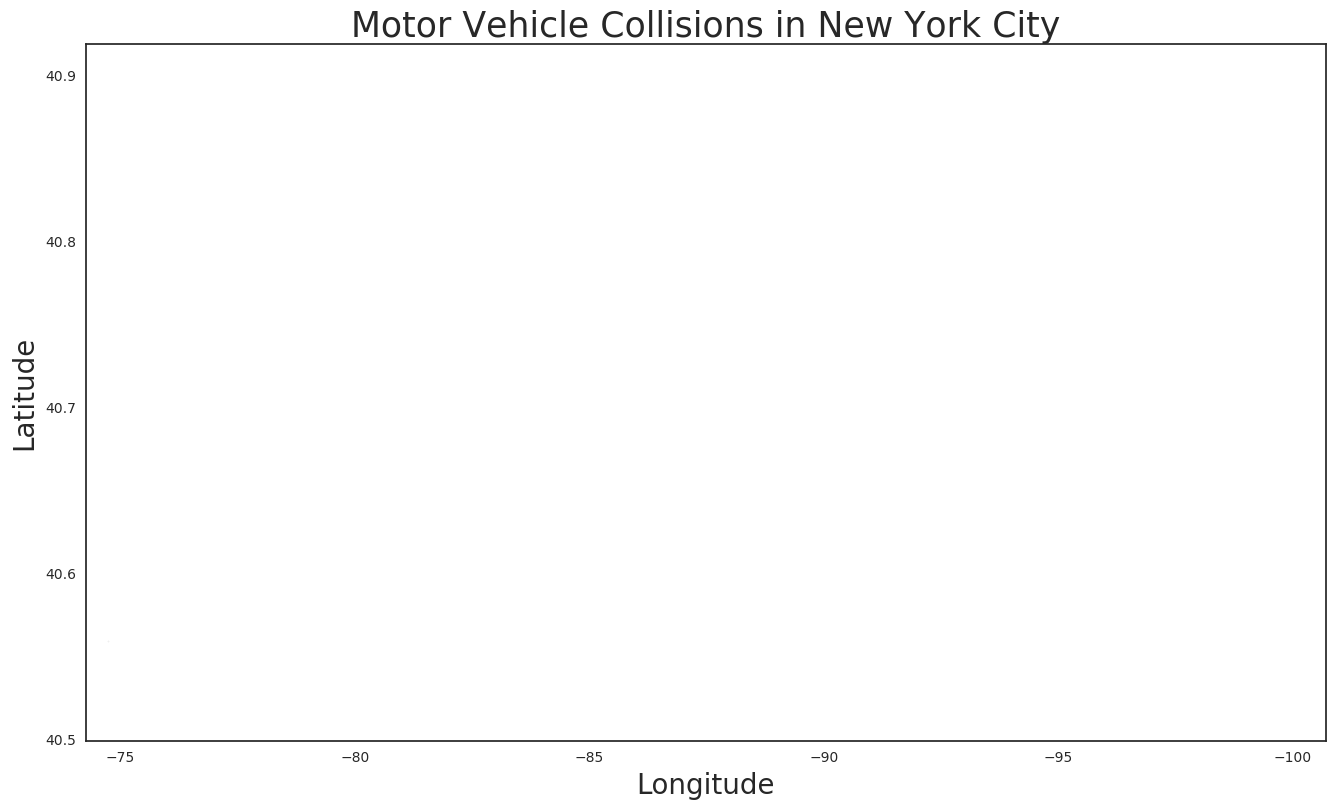

In [50]:
plt.figure(figsize=(16,9))
plt.scatter(collisions_pd_df.Longitude, collisions_pd_df.Latitude, alpha=0.05, s=1, color='black')
plt.title('Motor Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-100.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

### gotta look into why the scatter plot isnt coming

In [51]:
borough_df = collisions_spark_df.groupBy('BOROUGH').count().sort('count').toPandas()
borough_df.head(6)

,BOROUGH,count
0,STATEN ISLAND,22
1,BRONX,85
2,MANHATTAN,129
3,QUEENS,196
4,BROOKLYN,199
5,None,369


In [52]:
borough_df.set_value(5, 'BOROUGH', 'NOT KNOWN') #replace the 5th one borough 'none' with not known

,BOROUGH,count
0,STATEN ISLAND,22
1,BRONX,85
2,MANHATTAN,129
3,QUEENS,196
4,BROOKLYN,199
5,NOT KNOWN,369


In [53]:
%brunel data('borough_df') bar x(BOROUGH) y(count)

<IPython.core.display.Javascript object>

In [54]:
%brunel data('borough_df') bubble x(BOROUGH) color(BOROUGH) size(count) label(BOROUGH) sum(count) legends(none)

<IPython.core.display.Javascript object>